#**1. Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import urllib.request
from pathlib import Path
import joblib
import tarfile

from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# **2. Download data**

In [2]:
def download_data(url):
    file_name = Path(url).name
    urllib.request.urlretrieve(url, file_name)
    with tarfile.open(file_name, "r") as f:
        f.extractall()
    return pd.read_csv("/content/housing/housing.csv")


url = "https://github.com/ageron/data/raw/main/housing.tgz"
df = download_data(url)

In [3]:
#data overview
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
#Checking missing data
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
#Checking duplicates
df.duplicated().sum()

0

In [8]:
df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
#Summary data of numerical attributes
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


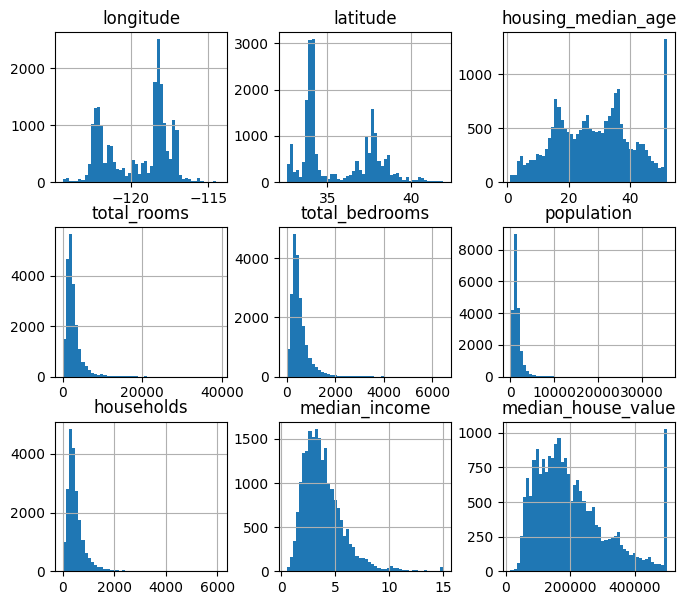

In [10]:
#Histogram plot
df.hist(bins=50, figsize=(8, 7))
plt.show()

**Observations**
1.   There are 10 attributes (columns) and 20640 instances/data points/rows. These instances also represent the various districts whose median house prices will be be predicted using this model.
2.   The column *total_bedrooms* has 207 missing values
3. There are no duplicates
4. All attributes are numerical data type except *ocean_proximity* which is object data type. Note, it is probably a categorical attribute with 5 categories.
5. *median_income* attribute is capped (*10,000).
6. For some instances, the attributes *housing_median_age* and *median_house_value* are capped. This can be addressed by either removing the affected instances or collecting correct lables.






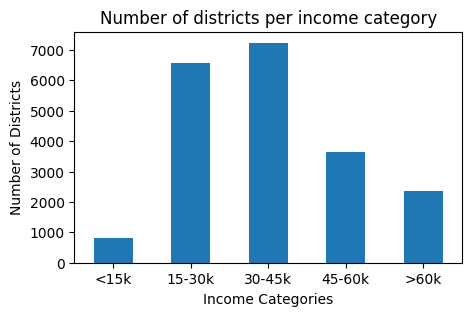

In [11]:
#Create income category column
df["income_cat"] = pd.cut(df["median_income"],
                          bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                          labels=[1, 2, 3, 4, 5])

#Income categories plot
labels = ["<15k", "15-30k", "30-45k", "45-60k", ">60k"]
income_cat = df["income_cat"].value_counts().sort_index()

plt.figure(figsize=(5, 3))
income_cat.plot(kind="bar", rot=0)
plt.xlabel("Income Categories")
plt.ylabel("Number of Districts")
plt.title("Number of districts per income category")

plt.xticks(ticks=range(len(income_cat)), labels=labels)
plt.show()


# **3. Data visualization and insights**

In [12]:
#Geographical visualization
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        color="median_house_value",
                        width=800,
                        height=600,
                        hover_data="median_house_value",
                        title="Geographical distribution of median housing values"
                        )

fig.update_layout(mapbox_style="open-street-map")
fig.show()


In [13]:
#Correlations
#pearson correlation betw median_house_value and other attributes
df.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

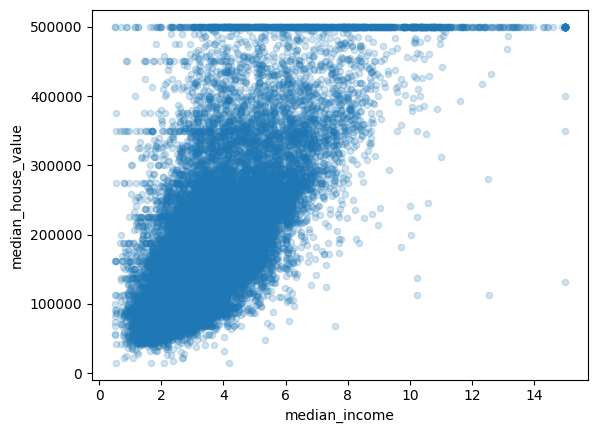

In [14]:
df.plot(kind="scatter", x="median_income", y="median_house_value",
        alpha=0.2)

In [15]:
#Create new attributes
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["people_per_household"] = df["population"] / df["households"]
df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"]

In [16]:
#Correlation matrix, including the new attributes
corr_matrix = df.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688075
rooms_per_household     0.151948
total_rooms             0.134153
housing_median_age      0.105623
households              0.065843
total_bedrooms          0.049686
people_per_household   -0.023737
population             -0.024650
longitude              -0.045967
latitude               -0.144160
bedrooms_ratio         -0.255880
Name: median_house_value, dtype: float64

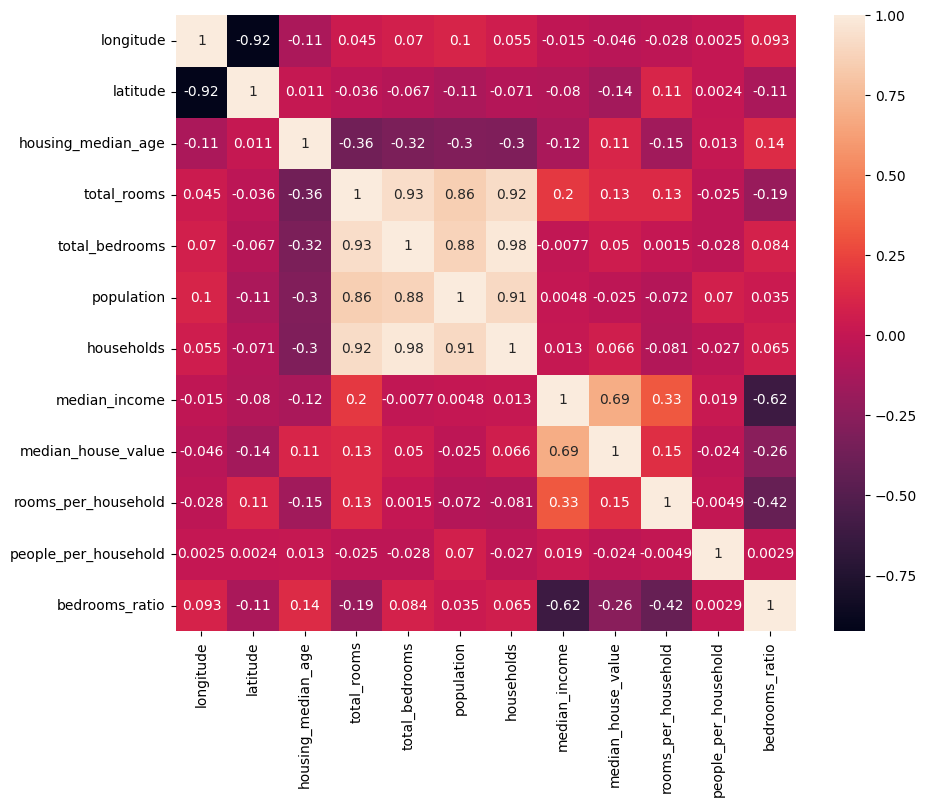

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# **4. Splitting data into training and testing sets**

In [18]:
#Drop multicolinearity columns
drop_columns = ["total_rooms", "total_bedrooms", "population", "income_cat"]
df.drop(columns=drop_columns, inplace=True)

#Split data into train and test sets
target = df["median_house_value"]
features = df.drop(columns="median_house_value")

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(16512, 9)

In [20]:
X_test.shape

(4128, 9)

In [21]:
y_train.shape

(16512,)

In [22]:
y_test.shape

(4128,)

# **5. Data preprocessing and transformation**

**Transformation Pipeline**


1. Impute missing values in numerical features and replace them with median
2. Impute missing values in categorical features and replace them with most frequent.
3. One-hot encode categorical features.
4. Standadize all numerical features







In [23]:
num_attributes = X_train.select_dtypes(include=[np.number]).columns.to_list()
cat_attributes = X_train.select_dtypes(include=[object]).columns.to_list()

In [24]:
#Numerical attributes pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

#Categorical attributes pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

#Preprocessing using column transformer
preprocessing = ColumnTransformer([
    ("numerical_pipeline", num_pipeline, num_attributes),
    ("categorical_pipeline", cat_pipeline, cat_attributes)
])

# **6. Select and train models**

**6.1 Baseline model**

In [25]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_rmse = mean_squared_error(y_train, y_pred_baseline, squared=False)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("mean housing value: ", y_mean.round(2))
print("baseline RMSE: ", baseline_rmse)
print("baseline MAE: ", baseline_mae)

mean housing value:  206111.15
baseline RMSE:  114786.59967922624
baseline MAE:  90566.65207337758


In [26]:
sum = 0
for i in y_train:
    for j in y_pred_baseline:
        square = (i - j) ** 2
    sum = sum + square
rmse = np.sqrt(sum / len(y_train))
print(rmse)
#len(y_pred_baseline)
#len(y_train)

114786.59967922632


**6.2 Linear Regression**

In [27]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'people_per_household',
                                                   'bedrooms_ratio']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [28]:
#Try model on training set
housing_prediction = lin_reg.predict(X_train)
print("prediction: ", housing_prediction[:5].round(2))

#compare with extact labels
print("Correct labels: ", y_train.iloc[:5].values)

prediction:  [275574.19 226147.87 254218.3  274791.7   17042.19]
Correct labels:  [291000. 156100. 353900. 241200.  53800.]


In [29]:
#Model's RMSE on the training set
lin_rmse = mean_squared_error(y_train, housing_prediction, squared=False)
print("linreg rsme on train set: ", lin_rmse)

linreg rsme on train set:  70017.77028650543


In [30]:
#Model's RMSE on the test set
lin_rmse = mean_squared_error(y_test, lin_reg.predict(X_test), squared=False)
print("linreg rsme on test set: ", lin_rmse)

linreg rsme on test set:  71805.98907758332


**6.3 Decision Tree Regressor**

In [31]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'people_per_household',
                                                   'bedrooms_ratio']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [33]:
#Evaluate model on training set using cross validation
tree_rmse = mean_squared_error(y_train, tree_reg.predict(X_train), squared=False)
tree_rmse = -cross_val_score(tree_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
print(pd.Series(tree_rmse).describe())

count       10.000000
mean     69255.540807
std       1831.876340
min      66921.468392
25%      67488.493337
50%      69599.589523
75%      70490.433482
max      72323.538853
dtype: float64


In [34]:
#Evaluate model on test set using cross validation
tree_rmse_test = mean_squared_error(y_test, tree_reg.predict(X_test), squared=False)
tree_rmse_test = -cross_val_score(tree_reg, X_test, y_test, scoring="neg_root_mean_squared_error", cv=10)
print(pd.Series(tree_rmse_test).describe())


count       10.000000
mean     78393.734898
std       4430.721585
min      72897.528727
25%      75616.768130
50%      77073.219441
75%      79916.940069
max      86914.268675
dtype: float64


**6.4 Random forest regressor**

In [35]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'people_per_household',
                                                   'bedrooms_ratio']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [36]:
#Evaluate model on training data
forest_rmse = mean_squared_error(y_train, forest_reg.predict(X_train),squared=False)
print("random forest regressor rmse: ", forest_rmse)

random forest regressor rmse:  18369.251149282652


In [37]:
forest_rmses = -cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_root_mean_squared_error", cv=10)

In [38]:
pd.Series(forest_rmses)

0    49098.600255
1    49291.329017
2    49324.034409
3    47592.103982
4    50967.179750
5    48392.603111
6    49849.077348
7    48404.698940
8    49571.321914
9    49408.181752
dtype: float64

In [39]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     49189.913048
std        920.637361
min      47592.103982
25%      48578.174269
50%      49307.681713
75%      49530.536873
max      50967.179750
dtype: float64

**7. Model fine tuning**

In [40]:
forest_reg.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity', 'rooms_per_household',
       'people_per_household', 'bedrooms_ratio'], dtype=object)

In [41]:
forest_reg.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numerical_pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['longitude', 'latitude', 'housing_median_age',
                                     'households', 'median_income',
                                     'rooms_per_household', 'people_per_household',
                                     'bedrooms_ratio']),
                                   ('categorical_pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
 

In [42]:
params = {"columntransformer__numerical_pipeline__simpleimputer__strategy": ["median", "mean"],
          "randomforestregressor__max_depth": [None, 15, 30, 45],
          "randomforestregressor__n_estimators": range (25, 100, 25)}

grid_search = GridSearchCV(
    forest_reg,
    param_grid=params,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'households',
                                                                          'median_income',
                                                                          'rooms_per_household',
                                                                          'people_per_household',
                                                                          'bedroo...
                                                                         ['ocean_proximity'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'columntransformer__numerical_pipeline__simpleimputer__strategy': ['median',
                                                                                            'mean'],
                         'randomforestregressor__max_depth': [None, 15, 30, 45],
                         'randomforestregressor__n_estimators': range(25, 100, 25)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [43]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__numerical_pipeline__simpleimputer__strategy,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,14.317725,0.554870,0.268152,0.076256,mean,30,75,{'columntransformer__numerical_pipeline__simpl...,-50263.300691,-50290.575224,-50360.194276,-50304.690064,40.796350,1
8,14.775771,0.215690,0.187413,0.022417,median,30,75,{'columntransformer__numerical_pipeline__simpl...,-50336.893322,-50284.706781,-50358.535602,-50326.711902,30.988382,2
14,14.502684,0.316871,0.209883,0.035689,mean,None,75,{'columntransformer__numerical_pipeline__simpl...,-50316.993315,-50309.071296,-50386.101846,-50337.388819,34.596810,3
23,14.564086,0.672662,0.168140,0.020924,mean,45,75,{'columntransformer__numerical_pipeline__simpl...,-50316.993315,-50309.071296,-50386.101846,-50337.388819,34.596810,3
11,14.376782,0.403930,0.269604,0.079322,median,45,75,{'columntransformer__numerical_pipeline__simpl...,-50329.084210,-50345.746868,-50375.344947,-50350.058675,19.130389,5


In [44]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_columntransformer__numerical_pipeline__simpleimputer__strategy',
       'param_randomforestregressor__max_depth',
       'param_randomforestregressor__n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [45]:
#Select and sort relevant columns
cv_results_df = cv_results[["mean_fit_time", "param_columntransformer__numerical_pipeline__simpleimputer__strategy",
                  "param_randomforestregressor__max_depth",
                  "param_randomforestregressor__n_estimators",
                  "split0_test_score", "split1_test_score",
                  "split2_test_score", "mean_test_score"
                  ]].sort_values(by="mean_test_score", ascending=False)

#Convert the - mean_test_score back to +
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_results_df.columns = ["fit_time", "simpleimputer__strategy", "max_depth", "n_estimators"] + score_cols

cv_results_df[score_cols] = -cv_results_df[score_cols].round().astype(np.int64)

cv_results_df.head()

,fit_time,simpleimputer__strategy,max_depth,n_estimators,split0,split1,split2,mean_test_rmse
20,14.317725,mean,30,75,50263,50291,50360,50305
8,14.775771,median,30,75,50337,50285,50359,50327
14,14.502684,mean,None,75,50317,50309,50386,50337
23,14.564086,mean,45,75,50317,50309,50386,50337
11,14.376782,median,45,75,50329,50346,50375,50350


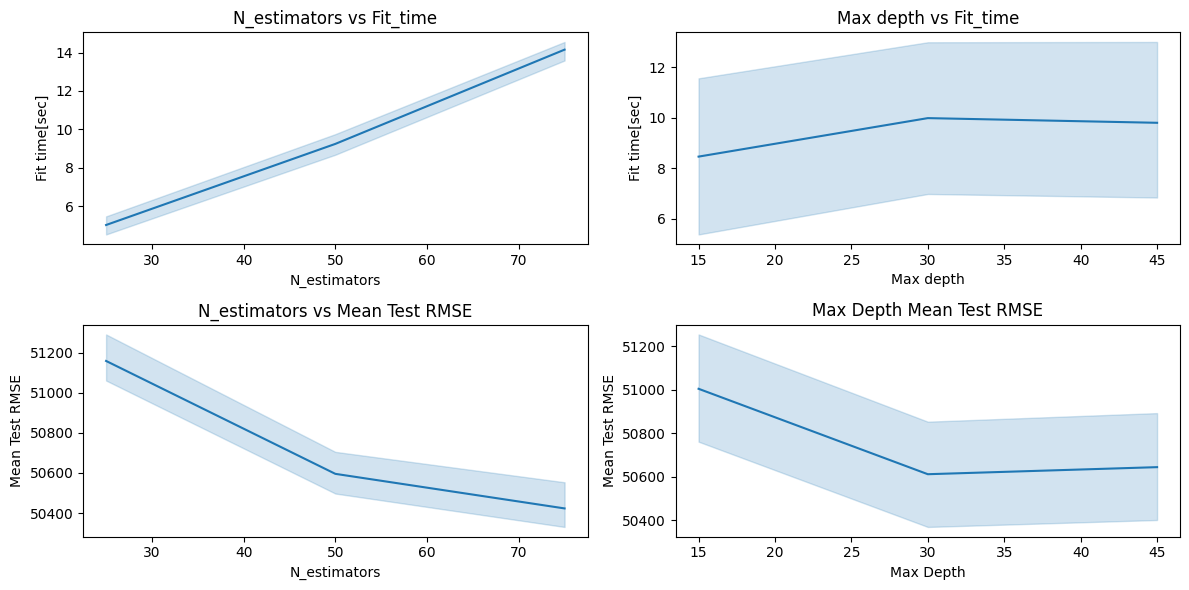

In [46]:
#Ploting the grid search results
#Create subplots
fig, axs=plt.subplots(2, 2, figsize=(12, 6))
#Subplot 1
sns.lineplot(data=cv_results_df, ax=axs[0,0], x='n_estimators', y='fit_time')
axs[0, 0].set_title("N_estimators vs Fit_time")
axs[0, 0].set_xlabel("N_estimators")
axs[0, 0].set_ylabel("Fit time[sec]")

#Subplot 2
sns.lineplot(data=cv_results_df, ax=axs[0,1], x='max_depth', y='fit_time')
axs[0, 1].set_title("Max depth vs Fit_time")
axs[0, 1].set_xlabel("Max depth")
axs[0, 1].set_ylabel("Fit time[sec]")

#Subplot 3
sns.lineplot(data=cv_results_df, ax=axs[1,0], x='n_estimators', y='mean_test_rmse')
axs[1, 0].set_title("N_estimators vs Mean Test RMSE")
axs[1, 0].set_xlabel("N_estimators")
axs[1, 0].set_ylabel("Mean Test RMSE")

#Subplot 4
sns.lineplot(data=cv_results_df, ax=axs[1,1], x='max_depth', y='mean_test_rmse')
axs[1, 1].set_title("Max Depth Mean Test RMSE")
axs[1, 1].set_xlabel("Max Depth")
axs[1, 1].set_ylabel("Mean Test RMSE")

plt.tight_layout()
plt.show()


**8. Analyze best model**

In [47]:
grid_search.best_params_

{'columntransformer__numerical_pipeline__simpleimputer__strategy': 'mean',
 'randomforestregressor__max_depth': 30,
 'randomforestregressor__n_estimators': 75}

In [48]:
#Get the best model
best_model = grid_search.best_estimator_
#get most important features
feature_imp = best_model["randomforestregressor"].feature_importances_


In [49]:
sorted(zip(feature_imp,
           best_model["columntransformer"].get_feature_names_out()),
           reverse=True)

[(0.4773559680695876, 'numerical_pipeline__median_income'),
 (0.14344220035738284, 'categorical_pipeline__ocean_proximity_INLAND'),
 (0.12349801300444435, 'numerical_pipeline__people_per_household'),
 (0.0604545446137654, 'numerical_pipeline__longitude'),
 (0.058949167810097694, 'numerical_pipeline__latitude'),
 (0.045416448710065754, 'numerical_pipeline__housing_median_age'),
 (0.02986849174776341, 'numerical_pipeline__rooms_per_household'),
 (0.029147135172181312, 'numerical_pipeline__households'),
 (0.02698426970837685, 'numerical_pipeline__bedrooms_ratio'),
 (0.002520868290869682, 'categorical_pipeline__ocean_proximity_NEAR OCEAN'),
 (0.00126881686422727, 'categorical_pipeline__ocean_proximity_<1H OCEAN'),
 (0.0008767370508438565, 'categorical_pipeline__ocean_proximity_NEAR BAY'),
 (0.0002173386003939506, 'categorical_pipeline__ocean_proximity_ISLAND')]

In [50]:
#Convert feature importances into a series
feature_names = best_model.named_steps["columntransformer"].get_feature_names_out()
feature_imp_series = pd.Series(feature_imp, index=feature_names).sort_values()
feature_imp_series

categorical_pipeline__ocean_proximity_ISLAND        0.000217
categorical_pipeline__ocean_proximity_NEAR BAY      0.000877
categorical_pipeline__ocean_proximity_<1H OCEAN     0.001269
categorical_pipeline__ocean_proximity_NEAR OCEAN    0.002521
numerical_pipeline__bedrooms_ratio                  0.026984
numerical_pipeline__households                      0.029147
numerical_pipeline__rooms_per_household             0.029868
numerical_pipeline__housing_median_age              0.045416
numerical_pipeline__latitude                        0.058949
numerical_pipeline__longitude                       0.060455
numerical_pipeline__people_per_household            0.123498
categorical_pipeline__ocean_proximity_INLAND        0.143442
numerical_pipeline__median_income                   0.477356
dtype: float64

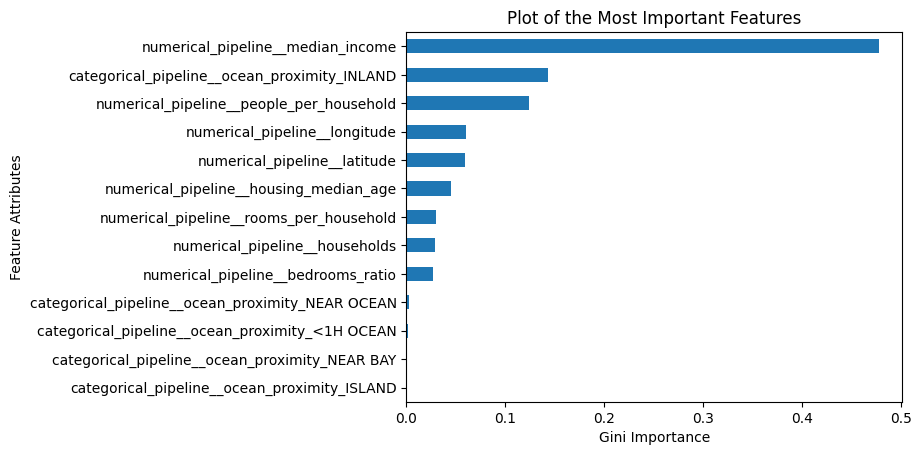

In [51]:
#Plot of the most important features
feature_imp_series.plot(kind="barh",
                 xlabel="Gini Importance",
                 ylabel="Feature Attributes",
                 title="Plot of the Most Important Features")
plt.show()

**9. Evaluating model on test set**

In [52]:
final_predictions = best_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print("Final RMSE is: ", final_rmse)

Final RMSE is:  51002.678837393265


**10. Hypothesis testing**
1. Is the final model better than existing model in production at 95% CI?
2. Compute 95% CI for the generalization error

In [53]:
conf_intv = 0.95
squared_errors = (final_predictions - y_test) ** 2
results = np.sqrt(
    stats.t.interval(conf_intv, len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors))
)
print(results)

[48601.86726407 53295.45004619]


In [54]:
squared_errors

20046    3.050379e+08
3024     2.206368e+09
15663    2.944566e+09
20484    1.755047e+10
9814     2.239323e+09
             ...     
15362    4.961794e+07
16623    4.204226e+07
18086    2.576667e+08
2144     4.431575e+08
3665     3.888450e+09
Name: median_house_value, Length: 4128, dtype: float64

# **11. Key Takeaways**
1. Randomfrestregressor performs best (low overfitting) compared to baseline, linear regression and decsion tree regressor.
2. Grid Search provided a set of best parameters for the randomforestregressor
3. We pick and proceed with the best model provided by the grid search
4. The final model performs well on the test set
5. Final RMSE is statistically significant at 95% confidence level
4. Household median income is the most important factors detemining median house price in California

#**12. Deployment**

In [55]:
#save the final model
model_filename = "California_housing_model.pkl"
joblib.dump(best_model, model_filename)

['California_housing_model.pkl']

In [56]:
def wrangle(df):
    """
    This wrangle function is created to perfrm preliminary
    data warangling conducted during data preprocessing
    """
    #Create new attributes
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["people_per_household"] = df["population"] / df["households"]
    df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"]

    #Drop multicolinearity columns
    drop_columns = ["total_rooms", "total_bedrooms", "population"]
    df.drop(columns=drop_columns, inplace=True)
    return df

In [57]:
#Make predictions on new data
new_data = pd.read_csv("new_data.csv")
new_data = wrangle(new_data)
best_model_loaded = joblib.load("California_housing_model.pkl")
predictions = best_model_loaded.predict(new_data)

In [58]:
pd.Series(predictions)

0    405997.426667
1    398100.080000
2    365810.760000
3    324341.333333
4    292349.333333
5    265509.333333
6    250864.000000
7    176186.666667
8    199684.000000
9    262084.000000
dtype: float64